In [1]:
import os
if os.path.basename(os.getcwd())=='experiments':
    os.chdir("./..")

In [2]:
import numpy as np
import pandas as pd
import sklearn.neighbors
from utils.data_preparation import *
from model.baseline_model import BaselineModel
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn.metrics 
from utils.evaluation import create_confusion_matrix, show_confusion_matrix, result_stats_size_model

LOAD_MODELS = False

## Used Datasets configuration

In [3]:
full_config = {"dataset": "renttherunway",
               "dataset_type": "full"}
test_train_config = {"dataset": "renttherunway",
                     "test_size": 0.1,
                     "random_state": 2022}
test_config = test_train_config.copy()
test_config["dataset_type"] = "test-stratified"
train_config = test_train_config.copy()
train_config["dataset_type"] = "train-stratified"
print("full dataset config\n", full_config)
print("test dataset config\n", test_config)
print("train dataset config\n", train_config)


full dataset config
 {'dataset': 'renttherunway', 'dataset_type': 'full'}
test dataset config
 {'dataset': 'renttherunway', 'test_size': 0.1, 'random_state': 2022, 'dataset_type': 'test-stratified'}
train dataset config
 {'dataset': 'renttherunway', 'test_size': 0.1, 'random_state': 2022, 'dataset_type': 'train-stratified'}


In [4]:
def config_string(config):
    result = f'{config["dataset"]}-{config["dataset_type"]}'
    if "test_size" in config:
        result+=f'-tsize={config["test_size"]}'
    if "random_state" in config:
        result+=f'-rand={config["random_state"]}'
    return result
full_on_full_datapath = f"baseline_results_teston_{config_string(full_config)}_trainon_{config_string(full_config)}"
test_on_full_datapath = f"baseline_results_teston_{config_string(test_config)}_trainon_{config_string(full_config)}"
test_on_train_datapath = f"baseline_results_teston_{config_string(test_config)}_trainon_{config_string(train_config)}"
train_on_train_datapath = f"baseline_results_teston_{config_string(train_config)}_trainon_{config_string(train_config)}"
print(full_on_full_datapath, test_on_full_datapath, test_on_train_datapath, train_on_train_datapath, sep="\n")


baseline_results_teston_renttherunway-full_trainon_renttherunway-full
baseline_results_teston_renttherunway-test-stratified-tsize=0.1-rand=2022_trainon_renttherunway-full
baseline_results_teston_renttherunway-test-stratified-tsize=0.1-rand=2022_trainon_renttherunway-train-stratified-tsize=0.1-rand=2022
baseline_results_teston_renttherunway-train-stratified-tsize=0.1-rand=2022_trainon_renttherunway-train-stratified-tsize=0.1-rand=2022


# Baseline model

$ p(\mathcal{S}, \mathcal{R} | \mathcal{C}, \mathcal{A}) =
p(\mathcal{S}|\mathcal{C}\mathcal{A})p(\mathcal{R}|\mathcal{C}\mathcal{A})$  

**Probability over sizes**  
$p(s|c_j) = \frac{1}{n_jh_j}\sum_{i=1}^{n_j} \phi(\frac{s-s_i}{h_j})
= \frac{1}{n_j}\sum_{i=1}^{n_j} \frac{1}{h_j\sqrt{2\pi}}e^{(\frac{s-s_i}{h_j})^2}$  
$= \frac{1}{n_j}\sum_{i=1}^{n_j} \mathcal{N}(s | s_i, h_j^2)$  
$= \frac{1}{n_jh_j\sqrt{2\pi}}\sum_{i=1}^{n_j} e^{(\frac{s-s_i}{h_j})^2}$   $

Where:  
$\phi$ - normal density function  
$h_j$ - bandwidth parameter for specific customer, for now we are using 1 for all customers. 

**Probablity over return status**  
$p(\mathcal{R}|\mathcal{C}\mathcal{A}) = p(\mathcal{R}|\mathcal{A})$  
$p(r|a_i) = \frac{n_{i, r} + 1}{n_i + 3}$   
Article $a_i$ was ordered $n_i$ times and got return status $r$ $n_{i, r}$ times.  

------------------

**NOTES:**  
We could add parameter like so:  
$p(r|a_i) = \frac{n_{i, r} + 
\rho}{n_i + 3\rho}$   


## Full Dataset test

In [5]:
if LOAD_MODELS:
    full_result = pd.read_csv(f"results/{full_on_full_datapath}.csv")
    test_on_full_result = pd.read_csv(f"results/{test_on_full_datapath}.csv")
else:
    df = get_data_from_config(full_config)
    test = get_data_from_config(test_config)
    bs = BaselineModel()
    bs.train_model(df)
    full_result = bs.full_predict_and_logprob(df)
    full_result.to_csv(f"results/{full_on_full_datapath}.csv", index=False)
    test_on_full_result = bs.full_predict_and_logprob(test)
    test_on_full_result.to_csv(f"results/{test_on_full_datapath}.csv", index=False)


In [6]:
full_result

,result_original,user_id_original,item_id_original,size,review_date,category,user_id,item_id,result,predicted_size,...,2,predicted_return_status,predicted_return_status_prob,predicted_return_status_logprob,return_status_prob,return_status_logprob,full_predicted_prob,full_predicted_logprob,full_prob,full_logprob
0,fit,420272,2260466,14,"April 20, 2016",romper,44334,4396,0,14,...,0.322581,0,0.645161,-0.438255,0.645161,-0.438255,0.177394,-1.729385,0.177394,-1.729385
1,fit,273551,153475,12,"June 18, 2013",gown,28835,65,0,12,...,0.080460,0,0.783525,-0.243952,0.783525,-0.243952,0.312581,-1.162891,0.312581,-1.162891
2,fit,360448,1063761,4,"December 14, 2015",sheath,37976,1945,0,4,...,0.250000,0,0.714286,-0.336472,0.714286,-0.336472,0.284959,-1.255411,0.284959,-1.255411
3,fit,909926,126335,8,"February 12, 2014",dress,96080,7,0,8,...,0.047683,0,0.748217,-0.290062,0.748217,-0.290062,0.298496,-1.209000,0.298496,-1.209000
4,fit,151944,616682,12,"September 26, 2016",gown,15959,1032,0,16,...,0.034188,0,0.931624,-0.070826,0.931624,-0.070826,0.265510,-1.326103,0.053184,-2.933999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,66386,2252812,8,"May 18, 2016",jumpsuit,7026,4382,0,8,...,0.021277,0,0.893617,-0.112478,0.893617,-0.112478,0.254678,-1.367755,0.254678,-1.367755
192540,fit,118398,682043,4,"September 30, 2016",dress,12494,1164,0,4,...,0.183099,0,0.746479,-0.292388,0.746479,-0.292388,0.199637,-1.611252,0.199637,-1.611252
192541,fit,47002,683251,8,"March 4, 2016",dress,5019,1166,0,8,...,0.255639,0,0.721805,-0.326001,0.721805,-0.326001,0.203995,-1.589662,0.203995,-1.589662
192542,fit,961120,126335,16,"November 25, 2015",dress,101534,7,0,16,...,0.047683,0,0.748217,-0.290062,0.748217,-0.290062,0.298496,-1.209000,0.298496,-1.209000


------ Return status results ------
Mean target probability:  0.627207998160124
Mean target log probability:  -0.6118634657298393
STATS:                precision    recall  f1-score   support

           0       0.77      0.97      0.86    142058
           1       0.67      0.20      0.30     24707
           2       0.64      0.18      0.28     25779

    accuracy                           0.76    192544
   macro avg       0.69      0.45      0.48    192544
weighted avg       0.74      0.76      0.71    192544



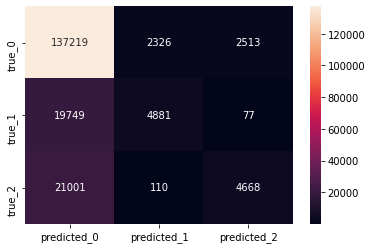

In [7]:
print("------ Return status results ------")
print("Mean target probability: ", full_result["return_status_prob"].mean())
print("Mean target log probability: ", full_result["return_status_logprob"].mean())
print("STATS: ", sklearn.metrics.classification_report(full_result["result"], full_result["predicted_return_status"]))
show_confusion_matrix(full_result, "result", "predicted_return_status")

In [8]:
print("------ Size results ------")
print("Mean target probability: ", full_result["size_prob"].mean())
print("Mean target log probability: ", full_result["size_logprob"].mean())
print("STATS: ", sklearn.metrics.classification_report(full_result["size"], full_result["predicted_size"]))
#show_confusion_matrix(full_result, "size", "predicted_size")

------ Size results ------
Mean target probability:  0.29663856459606497
Mean target log probability:  -1.3219672449644497


/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


STATS:                precision    recall  f1-score   support

           0       0.81      0.77      0.79       526
           1       0.79      0.84      0.81     13719
           2       0.74      0.72      0.73       729
           3       0.69      0.74      0.72       711
           4       0.77      0.82      0.80     29562
           5       0.82      0.74      0.78      1739
           6       1.00      0.22      0.36         9
           7       0.80      0.73      0.76       673
           8       0.78      0.82      0.80     40804
           9       0.84      0.74      0.79      2651
          10       1.00      1.00      1.00         3
          11       0.79      0.71      0.75       437
          12       0.77      0.72      0.75     24702
          13       0.43      0.76      0.55      2573
          14       0.69      0.49      0.58     11921
          15       0.11      0.66      0.19       353
          16       0.77      0.72      0.74     17668
          17       

/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packa

In [12]:

print("------ Combined result ------")
print("Mean target probability: ", full_result["full_prob"].mean(), "std = ", full_result["full_prob"].std())
print("Mean target log probability: ", full_result["full_logprob"].mean(), "std =", full_result["full_logprob"].std())

------ Combined result ------
Mean target probability:  0.1882236758509267 std =  0.10731636240798872
Mean target log probability:  -1.9338307106942894 std = 0.8599221039386169


In [13]:
print("Size model stats")
print(result_stats_size_model(full_result))

Size model stats
{'mean_target_probability': 0.29663856459606497, 'mean_log_target_probability': -1.3219672449644497, 'RMSE': 2.401202410900701, 'accuracy': 0.7614934768156889, 'f1_micro': 0.7614934768156889, 'f1_macro': 0.683051252848609, 'f1_weighted': 0.7629434248009157}


## Testset trained on full dataset

TRAIN DATA
------ Return status results ------
Mean target probability:  0.6192061021549563
Mean target log probability:  -0.6203967581360276
STATS:                precision    recall  f1-score   support

           0       0.76      0.96      0.85      8439
           1       0.64      0.22      0.32      1555
           2       0.63      0.19      0.29      1583

    accuracy                           0.75     11577
   macro avg       0.68      0.45      0.49     11577
weighted avg       0.73      0.75      0.70     11577

------ Size results ------
Mean target probability:  0.23462420880004148
Mean target log probability:  -1.5670045820779572
------ Combined result ------
Mean target probability:  0.14727973015798101 std =  0.09017788815908118
Mean target log probability:  -2.1874013402139845 std =  0.8620604402510462


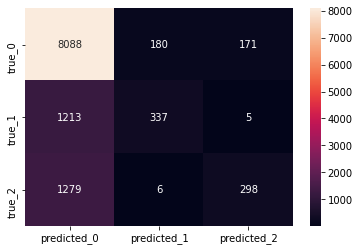

In [15]:
print("TRAIN DATA")
print("------ Return status results ------")
print("Mean target probability: ", test_on_full_result["return_status_prob"].mean())
print("Mean target log probability: ", test_on_full_result["return_status_logprob"].mean())
print("STATS: ", sklearn.metrics.classification_report(test_on_full_result["result"], test_on_full_result["predicted_return_status"]))
show_confusion_matrix(test_on_full_result, "result", "predicted_return_status")
print("------ Size results ------")
print("Mean target probability: ", test_on_full_result["size_prob"].mean())
print("Mean target log probability: ", test_on_full_result["size_logprob"].mean())
print("------ Combined result ------")
print("Mean target probability: ", test_on_full_result["full_prob"].mean(), "std = ", test_on_full_result["full_prob"].std())
print("Mean target log probability: ", test_on_full_result["full_logprob"].mean(), "std = ", test_on_full_result["full_logprob"].std())

In [16]:
print("Size model stats")
print(result_stats_size_model(test_on_full_result))

Size model stats
{'mean_target_probability': 0.23462420880004148, 'mean_log_target_probability': -1.5670045820779572, 'RMSE': 3.0128858612216654, 'accuracy': 0.6195905675045349, 'f1_micro': 0.6195905675045349, 'f1_macro': 0.34559671733085595, 'f1_weighted': 0.619706655901337}


## Test on split dataset

In [17]:
if LOAD_MODELS:
    train_result = pd.read_csv(f"results/{train_on_train_datapath}.csv")
    test_result = pd.read_csv(f"results/{test_on_train_datapath}.csv")
else:
    bs = BaselineModel()
    train = get_data_from_config(train_config)
    bs.train_model(train)
    train_result = bs.full_predict_and_logprob(train)
    train_result.to_csv(f"results/{train_on_train_datapath}.csv", index=False)
    test_result = bs.full_predict_and_logprob(test)
    test_result.to_csv(f"results/{test_on_train_datapath}.csv")



TRAIN DATA
------ Return status results ------
Mean target probability:  0.6271614345300044
Mean target log probability:  -0.6110151476907
STATS:                precision    recall  f1-score   support

           0       0.77      0.97      0.86    133619
           1       0.67      0.20      0.31     23152
           2       0.65      0.18      0.28     24196

    accuracy                           0.76    180967
   macro avg       0.70      0.45      0.48    180967
weighted avg       0.74      0.76      0.71    180967

------ Size results ------
Mean target probability:  0.30452022833050935
Mean target log probability:  -1.2893586277284532
------ Combined result ------
Mean target probability:  0.19304900984592166 std =  0.10772172267947193
Mean target log probability:  -1.9003737754191528 std =  0.8472108522480626


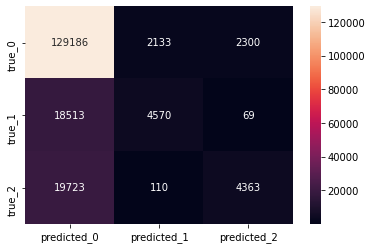

In [18]:
print("TRAIN DATA")
print("------ Return status results ------")
print("Mean target probability: ", train_result["return_status_prob"].mean())
print("Mean target log probability: ", train_result["return_status_logprob"].mean())
print("STATS: ", sklearn.metrics.classification_report(train_result["result"], train_result["predicted_return_status"]))
show_confusion_matrix(train_result, "result", "predicted_return_status")
print("------ Size results ------")
print("Mean target probability: ", train_result["size_prob"].mean())
print("Mean target log probability: ", train_result["size_logprob"].mean())
print("------ Combined result ------")
print("Mean target probability: ", train_result["full_prob"].mean(), "std = ", train_result["full_prob"].std())
print("Mean target log probability: ", train_result["full_logprob"].mean(), "std = ", train_result["full_logprob"].std())

In [19]:
train_size_classification_stats = sklearn.metrics.classification_report(train_result["size"], train_result["predicted_size"])
print(train_size_classification_stats)


/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packa

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       513
           1       0.81      0.85      0.83     12945
           2       0.77      0.75      0.76       696
           3       0.71      0.78      0.74       684
           4       0.78      0.84      0.81     27692
           5       0.84      0.76      0.80      1656
           6       1.00      0.29      0.44         7
           7       0.80      0.77      0.79       648
           8       0.79      0.83      0.81     38113
           9       0.87      0.77      0.82      2526
          10       1.00      1.00      1.00         3
          11       0.80      0.74      0.77       418
          12       0.80      0.74      0.76     23221
          13       0.45      0.79      0.58      2454
          14       0.71      0.52      0.60     11073
          15       0.12      0.70      0.20       340
          16       0.79      0.74      0.76     16620
          17       0.86    

/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print("Mean target probability: ", train_result["size_prob"].mean())
print("Mean target log probability: ", train_result["size_logprob"].mean())
print("Size model stats:")
print(result_stats_size_model(train_result))


Mean target probability:  0.30452022833050935
Mean target log probability:  -1.2893586277284532
Size model stats:
{'mean_target_probability': 0.30452022833050935, 'mean_log_target_probability': -1.2893586277284532, 'RMSE': 2.316582184588656, 'accuracy': 0.7784900009393978, 'f1_micro': 0.7784900009393977, 'f1_macro': 0.7153835190818212, 'f1_weighted': 0.7802303846622615}


TEST DATA
------ Return status results ------
Mean target probability:  0.605702052959929
Mean target log probability:  -0.6642480898360711
STATS:                precision    recall  f1-score   support

           0       0.76      0.95      0.84      8439
           1       0.57      0.19      0.29      1555
           2       0.55      0.17      0.26      1583

    accuracy                           0.74     11577
   macro avg       0.63      0.44      0.46     11577
weighted avg       0.70      0.74      0.69     11577

------ Size results ------
Mean target probability:  0.17318677069388905
Mean target log probability:  -5.30398155593761
------ Combined result ------
Mean target probability:  0.10747194200947312 std =  0.10655623295370813
Mean target log probability:  -5.968229645773682 std =  12.407469731691034


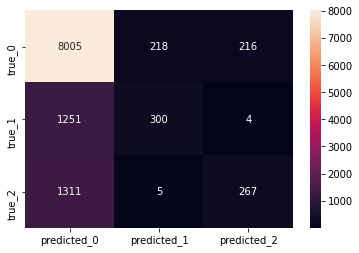

In [22]:
print("TEST DATA")
print("------ Return status results ------")
print("Mean target probability: ", test_result["return_status_prob"].mean())
print("Mean target log probability: ", test_result["return_status_logprob"].mean())
print("STATS: ", sklearn.metrics.classification_report(test_result["result"], test_result["predicted_return_status"]))
show_confusion_matrix(test_result, "result", "predicted_return_status")
print("------ Size results ------")
print("Mean target probability: ", test_result["size_prob"].mean())
print("Mean target log probability: ", test_result["size_logprob"].mean())
print("------ Combined result ------")
print("Mean target probability: ", test_result["full_prob"].mean(), "std = ", test_result["full_prob"].std())
print("Mean target log probability: ", test_result["full_logprob"].mean(), "std = ", test_result["full_logprob"].std())

In [23]:
test_size_classification_stats = sklearn.metrics.classification_report(test_result["size"], test_result["predicted_size"])
print(test_size_classification_stats)

              precision    recall  f1-score   support

           0       0.10      0.15      0.12        13
           1       0.49      0.54      0.51       774
           2       0.05      0.03      0.04        33
           3       0.05      0.07      0.06        27
           4       0.50      0.53      0.52      1870
           5       0.23      0.19      0.21        83
           6       0.00      0.00      0.00         2
           7       0.07      0.08      0.07        25
           8       0.54      0.56      0.55      2691
           9       0.18      0.14      0.15       125
          11       0.06      0.05      0.06        19
          12       0.40      0.36      0.38      1481
          13       0.08      0.18      0.12       119
          14       0.26      0.18      0.21       848
          15       0.00      0.00      0.00        13
          16       0.38      0.34      0.36      1048
          17       0.14      0.14      0.14        69
          18       0.00    

/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martyna/.local/lib/python3.8/site-packa

In [24]:
print("Mean target probability: ", test_result["size_prob"].mean())
print("Mean target log probability: ", test_result["size_logprob"].mean())
print("Size model stats:")
print(result_stats_size_model(test_result))

Mean target probability:  0.17318677069388905
Mean target log probability:  -5.30398155593761
Size model stats:
{'mean_target_probability': 0.17318677069388905, 'mean_log_target_probability': -5.30398155593768, 'RMSE': 3.737152996091531, 'accuracy': 0.4358642135268204, 'f1_micro': 0.43586421352682037, 'f1_macro': 0.1670958559155178, 'f1_weighted': 0.435325217738675}


## Size model overview

In [25]:
print("Full on full: ")
print(result_stats_size_model(full_result))

Full on full: 
{'mean_target_probability': 0.29663856459606497, 'mean_log_target_probability': -1.3219672449644497, 'RMSE': 2.401202410900701, 'accuracy': 0.7614934768156889, 'f1_micro': 0.7614934768156889, 'f1_macro': 0.683051252848609, 'f1_weighted': 0.7629434248009157}


In [26]:
print("Test on full: ")
print(result_stats_size_model(test_on_full_result))

Test on full: 
{'mean_target_probability': 0.23462420880004148, 'mean_log_target_probability': -1.5670045820779572, 'RMSE': 3.0128858612216654, 'accuracy': 0.6195905675045349, 'f1_micro': 0.6195905675045349, 'f1_macro': 0.34559671733085595, 'f1_weighted': 0.619706655901337}


In [27]:
print("train on train: ")
print(result_stats_size_model(train_result))

train on train: 
{'mean_target_probability': 0.30452022833050935, 'mean_log_target_probability': -1.2893586277284532, 'RMSE': 2.316582184588656, 'accuracy': 0.7784900009393978, 'f1_micro': 0.7784900009393977, 'f1_macro': 0.7153835190818212, 'f1_weighted': 0.7802303846622615}


In [28]:
print("test on train: ")
print(result_stats_size_model(test_result))

test on train: 
{'mean_target_probability': 0.17318677069388905, 'mean_log_target_probability': -5.30398155593768, 'RMSE': 3.737152996091531, 'accuracy': 0.4358642135268204, 'f1_micro': 0.43586421352682037, 'f1_macro': 0.1670958559155178, 'f1_weighted': 0.435325217738675}
